In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve
import statsmodels.api as sm
from math import log,sqrt,exp
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
def option_price(S, X, T, r, q, sigma, option='Call'):
    d1 = (np.log(S / X) + (r - q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option == 'Call':
        value = S * np.exp(-q * T) * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'Put':
        value = X * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    else:
        print("The input option is not valid")
    return value
def find_implied_volatility(S,X,T,r,q, value, initvol, option = 'Call'):
    option = str(option)
    def sol_vol(sigma, S, X, T, r, q, option, value):
        return option_price(S, X, T, r, q, sigma, option = option) - value
    vol = fsolve(sol_vol, initvol, args=(S, X, T, r, q, option, value))
    return vol[0]
S =170.15
r = 0.0525
q = 0.0057
aapl_options = pd.read_csv("AAPL_Options.csv")
curdate= dt.datetime(2023,10,30)
aapl_options['Expiration']=aapl_options['Expiration'].astype("datetime64[ns]")
aapl_options['T'] = aapl_options['Expiration'].apply(lambda x: round((x-curdate).days/365,6))
def row_fun(row, S, r, q):
    vol = find_implied_volatility(S, row['Strike'], row['T'], r, q, row['Last Price'], 0.2, row['Type'])
    return vol
aapl_options['Implied Vol'] = aapl_options.apply(row_fun, args = (S, r, round(r-q,4)), axis=1)

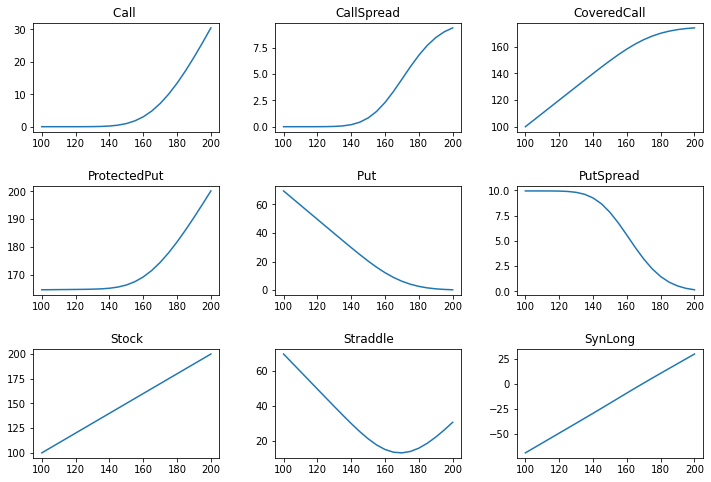

In [3]:
portfolio = pd.read_csv("problem3.csv")
curdate = dt.datetime(2023,10,30)
portfolio['ExpirationDate']=portfolio['ExpirationDate'].astype("datetime64[ns]")
portfolio['T'] = portfolio['ExpirationDate'].apply(lambda x: round((x-curdate).days/365,6))

# Caculate implied volatility
def row_function_portfolio(row,S,r,q):
    vol = find_implied_volatility(S,row['Strike'],row['T'],r,q,row['CurrentPrice'],0.2, row['OptionType'])
    return vol
portfolio['Implied Vol'] = portfolio[portfolio['Type']=='Option'].apply(row_function_portfolio,args=(S,r,round(r-q,4)),axis=1)
# Calculate value for each option given the underlying
def value_calculation(row,S,r,q,daysahead):
    if row['Type'] == 'Stock':
        return S
    else:
        return option_price(S,row['Strike'],row['T']-daysahead/365,r,q,row['Implied Vol'],row['OptionType'])*row['Holding']
underlying_list = np.linspace(100,200,num=21).tolist()
portfolio_values = pd.DataFrame(portfolio['Portfolio'])
for S in underlying_list:
    portfolio_values[S]=portfolio.apply(value_calculation,args=(S,r,round(r-q,4),0),axis=1)
# Portfolio values under the range
portfolio_range = portfolio_values.groupby('Portfolio').sum().T
# Plot the shape for each portfolio
fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(12,8))
for i in range(len(portfolio_range.columns)):
    x_ax = i // 3
    y_ax = i % 3
    portfolio_name = portfolio_range.columns[i]
    axs[x_ax,y_ax].plot(portfolio_range.index,portfolio_range[portfolio_name])
    axs[x_ax,y_ax].set_title(portfolio_name)
fig.subplots_adjust(wspace=0.3, hspace=0.5)

In [4]:
daily_prices = pd.read_csv("DailyPrices.csv")
# Calculate the log returns of AAPL
aapl_log = np.log(daily_prices['AAPL']/daily_prices['AAPL'].shift(1))
# Demean the series so there is 0 mean
aapl_log = aapl_log-aapl_log.mean()
# Simulate using AR1
def ar1_sim(r,ndays,p0,nsim=10000,seed=10):
    ar1_fit = sm.tsa.arima.ARIMA(r, order=(1, 0, 0))
    con,beta,s= ar1_fit.fit().params[0],ar1_fit.fit().params[1],np.sqrt(ar1_fit.fit().params[2])
    np.random.seed(seed)
    rsim = np.zeros((nsim,ndays))
    for i in range(nsim):
        rsim[i,0] = con+ beta*r.iloc[-1] + s*np.random.normal()
        for j in range(1,ndays):
            rsim[i,j]=con+ beta*rsim[i,j-1] + s*np.random.normal()
    rsim_cum = np.sum(rsim,axis=1)
    psim = np.zeros(nsim)
    for i in range(nsim):
        psim[i]=p0*exp(rsim_cum[i])
    return psim
underlying_sim = ar1_sim(aapl_log,10,S,seed=20)
portfolio_current = portfolio.apply(value_calculation,args=(S,r,round(r-q,4),0),axis=1)
pl_list = []
for i in range(len(underlying_sim)):
    pl = portfolio.apply(value_calculation,args=(underlying_sim[i],r,round(r-q,4),10),axis=1) - portfolio_current
    pl_list.append(pl)
pl_sim = pd.concat(pl_list,axis=1)
pl_sim.set_index(portfolio['Portfolio'],inplace=True)
port_sim = pl_sim.groupby(level=0).sum().T
def VaR(a,alpha=0.05):
    a.sort()
    v= np.quantile(a,alpha)
    return -v
def ES(a,alpha=0.05):
    a.sort()
    v= np.quantile(a,alpha)
    es = a[a<=v].mean()
    return -es
# Calculate Mean, VaR and ES
portfolio_mean = port_sim.mean(axis=0)
portfolio_stat = pd.DataFrame(portfolio_mean,columns=['Mean'])
var = []
es =[]
for col in port_sim.columns:
    var.append(VaR(port_sim[col].values))
    es.append(ES(port_sim[col].values))
portfolio_stat['VaR'] = var
portfolio_stat['ES'] = es
portfolio_stat

,Mean,VaR,ES
Portfolio,,,
Call,0.604972,15.797181,18.914327
CallSpread,-0.160003,1.986177,2.990954
CoveredCall,-0.130899,2.454929,4.122473
ProtectedPut,0.584594,16.685168,20.277700
Put,0.098163,0.273888,0.276006
PutSpread,0.077448,0.157878,0.159198
Stock,0.535874,17.441673,21.771266
Straddle,0.703135,14.538330,16.547867
SynLong,0.506809,17.056031,21.280787
